# Spring lattice sketch


## Imports


In [1]:

# from typing import NamedTuple, Optional, Callable, Dict, Any, Tuple, List, Union
# from dataclasses import dataclass
import scipy.io
# import jax.numpy as jnp
import pandas as pd
# from jax import grad, vmap, jacobian
# from jax.experimental.ode import odeint
# from jax._src.config import config
# config.update("jax_enable_x64", True)  # enable float64 type

# %matplotlib widget
# plt.style.use(["science", "grid"])

from morphing_lattices.plotting import plot_lattice
from morphing_lattices.structure import ControlParams, Lattice
from morphing_lattices.dynamics import setup_dynamic_solver
from morphing_lattices.geometry import triangular_lattice_connectivity, triangular_lattice_points
from morphing_lattices.kinematics import build_strain_fn, rotation_matrix
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type

%matplotlib widget
plt.style.use(["science", "grid"])



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Thermally responsive mass-spring lattice


### Import experimental data

In [2]:
exp_actuation_strain = pd.read_csv('../exp/mechanical_data/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv').drop(['Unnamed: 3'], axis=1)
exp_modulus_stress = pd.read_csv('../exp/mechanical_data/LTNI and HTNI LCE strains and moduli from Arda.csv')
exp_modulus_stress.drop(exp_modulus_stress.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, -1]], axis=1, inplace=True)
exp_modulus_stress.columns = exp_modulus_stress.iloc[0]
exp_modulus_stress.drop(0, inplace=True)

exp_modulus_fine = pd.read_csv('../exp/mechanical_data/youngs_mod_LCEstrips_DataForBertoldiGroup_updated202307.csv')
exp_modulus_fine.columns = ['Temp', 'LTNI_avg_young', 'LTNI_stdev', 'HTNI_avg_young', 'HTNI_stdev']
exp_modulus_fine.drop([0,1], inplace=True)
exp_modulus_fine = exp_modulus_fine.reset_index(drop=True)

HTNI_stretch_data = exp_actuation_strain[['temp [C]', 'AVG HTNI', 'STD HTNI']].astype(float)
LTNI_stretch_data = exp_actuation_strain[['temp [C]', 'AVG LTNI', 'STD LTNI']].astype(float)

HTNI_modulus_data = exp_modulus_stress[['Temp [C] corresponding to HTNI data', 'Avg Youngs Modulus of HTNI [Mpa]']].dropna().astype(float)
LTNI_modulus_data = exp_modulus_stress[['Temp [C] corresponding to LTNI data', 'Avg Youngs Modulus of LTNI [Mpa]']].dropna().astype(float)

LTNI_modulus_data_fine = exp_modulus_fine[['Temp', 'LTNI_avg_young']].astype(float)
HTNI_modulus_data_fine = exp_modulus_fine[['Temp', 'HTNI_avg_young']].astype(float)

sampled_temps = jnp.array([22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130])
ts = jnp.linspace(0, 9000, len(sampled_temps)) # used for interpolation

# Experimental tracking data
LTNI_all_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_F1_LTNI/LTNI_x_positions_transformed.mat')['LTNI_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
LTNI_all_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_F1_LTNI/LTNI_y_positions_transformed.mat')['LTNI_y_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_all_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_G1_HTNI/HTNI_x_positions_transformed.mat')['HTNI_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_all_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_G1_HTNI/HTNI_y_positions_transformed.mat')['HTNI_y_positions_transformed'] # [mm] <num nodes x num sampled temps>

LTNI_teeth_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_E1_LTNIteeth/LTNI_teeth_x_positions_transformed.mat')['LTNI_teeth_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
LTNI_teeth_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_E1_LTNIteeth/LTNI_teeth_y_positions_transformed.mat')['LTNI_teeth_y_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_teeth_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_B2_HTNIteeth/HTNI_teeth_x_positions_transformed.mat')['HTNI_teeth_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_teeth_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_B2_HTNIteeth/HTNI_teeth_y_positions_transformed.mat')['HTNI_teeth_y_positions_transformed'] # [mm] <num nodes x num sampled temps>

LTNI_pacman_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_H1_LTNIpacman/LTNI_pacman_x_positions_transformed.mat')['LTNI_pacman_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
LTNI_pacman_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_H1_LTNIpacman/LTNI_pacman_y_positions_transformed.mat')['LTNI_pacman_y_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_pacman_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_J1_HTNIpacman/HTNI_pacman_x_positions_transformed.mat')['HTNI_pacman_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_pacman_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_J1_HTNIpacman/HTNI_pacman_y_positions_transformed.mat')['HTNI_pacman_y_positions_transformed'] # [mm] <num nodes x num sampled temps>

In [3]:
# rotate the experimental data

def find_rotated_positions(x_positions, y_positions):

    n_temps = x_positions.shape[1]

    x_positions_rotated = jnp.zeros_like(x_positions)
    y_positions_rotated = jnp.zeros_like(y_positions)

    for i in jnp.arange(n_temps):
        x_pos_i = x_positions[:, i]
        y_pos_i = y_positions[:, i]

        # five_high_xind = jnp.argsort(x_pos_i)[-5:]
        five_low_yind = jnp.argsort(y_pos_i)[:5]

        bottom_row_xvals = x_pos_i[five_low_yind]

        max_bottom_row_xvals_ind = jnp.argmax(bottom_row_xvals)
        nodeXind = five_low_yind[max_bottom_row_xvals_ind]

        rotation_angle = -jnp.arctan(y_pos_i[nodeXind] / x_pos_i[nodeXind]) # angle in radians

        OGpts = jnp.array([x_pos_i, y_pos_i])
        rot_pts = jnp.dot(rotation_matrix(rotation_angle), OGpts)

        x_positions_rotated = x_positions_rotated.at[:, i].set(rot_pts[0, :])
        y_positions_rotated = y_positions_rotated.at[:, i].set(rot_pts[1, :])

    return x_positions_rotated, y_positions_rotated

LTNI_teeth_x_posj, LTNI_teeth_y_posj = find_rotated_positions(LTNI_teeth_x_posi, LTNI_teeth_y_posi)
HTNI_teeth_x_posj, HTNI_teeth_y_posj = find_rotated_positions(HTNI_teeth_x_posi, HTNI_teeth_y_posi)

LTNI_pacman_x_posj, LTNI_pacman_y_posj = find_rotated_positions(LTNI_pacman_x_posi, LTNI_pacman_y_posi)
HTNI_pacman_x_posj, HTNI_pacman_y_posj = find_rotated_positions(HTNI_pacman_x_posi, HTNI_pacman_y_posi)

HTNI_all_x_posj, HTNI_all_y_posj = find_rotated_positions(HTNI_all_x_posi, HTNI_all_y_posi)
LTNI_all_x_posj, LTNI_all_y_posj = find_rotated_positions(LTNI_all_x_posi, LTNI_all_y_posi)

In [4]:
origin_at_central_node = True # if True, the central node will be plotted at the origin. if False, the bottom left node will be plotted at the origin

def central_node_centering(x_positions, y_positions):

    x_positions_recentered = jnp.zeros_like(x_positions)
    y_positions_recentered = jnp.zeros_like(y_positions)

    n_temps = x_positions.shape[1]

    for j in jnp.arange(n_temps):

        avg_xpos = jnp.mean(x_positions[:, j])
        avg_ypos = jnp.mean(y_positions[:, j])

        central_x_index = jnp.argmin(jnp.abs(x_positions[:, j] - avg_xpos))
        central_y_index = jnp.argmin(jnp.abs(y_positions[:, j] - avg_ypos))

        x_positions_recentered = x_positions_recentered.at[:, j].set(x_positions[:, j] - x_positions[central_x_index, j])
        y_positions_recentered = y_positions_recentered.at[:, j].set(y_positions[:, j] - y_positions[central_y_index, j])

    return x_positions_recentered, y_positions_recentered

if origin_at_central_node:

    LTNI_teeth_x_pos, LTNI_teeth_y_pos = central_node_centering(LTNI_teeth_x_posj, LTNI_teeth_y_posj)
    HTNI_teeth_x_pos, HTNI_teeth_y_pos = central_node_centering(HTNI_teeth_x_posj, HTNI_teeth_y_posj)

    LTNI_pacman_x_pos, LTNI_pacman_y_pos = central_node_centering(LTNI_pacman_x_posj, LTNI_pacman_y_posj)
    HTNI_pacman_x_pos, HTNI_pacman_y_pos = central_node_centering(HTNI_pacman_x_posj, HTNI_pacman_y_posj)

    HTNI_all_x_pos, HTNI_all_y_pos = central_node_centering(HTNI_all_x_posj, HTNI_all_y_posj)
    LTNI_all_x_pos, LTNI_all_y_pos = central_node_centering(LTNI_all_x_posj, LTNI_all_y_posj)

else:

    LTNI_all_x_pos = LTNI_all_x_posj
    LTNI_all_y_pos = LTNI_all_y_posj
    HTNI_all_x_pos = HTNI_all_x_posj
    HTNI_all_y_pos = HTNI_all_y_posj

    LTNI_teeth_x_pos = LTNI_teeth_x_posj
    LTNI_teeth_y_pos = LTNI_teeth_y_posj
    HTNI_teeth_x_pos = HTNI_teeth_x_posj
    HTNI_teeth_y_pos = HTNI_teeth_y_posj

    LTNI_pacman_x_pos = LTNI_pacman_x_posj
    LTNI_teeth_y_pos = LTNI_pacman_y_posj
    HTNI_pacman_x_pos = HTNI_pacman_x_posj
    HTNI_teeth_y_pos = HTNI_pacman_y_posj

In [5]:
def T(time):
    return jnp.interp(time, ts, sampled_temps)

def HTNI_stretch(temperature): # normalized length
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))

def LTNI_stretch(temperature): # normalized length
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))

def LTNI_young_fit(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data['Temp [C] corresponding to LTNI data']), jnp.array(LTNI_modulus_data['Avg Youngs Modulus of LTNI [Mpa]']))

def HTNI_young_fit(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data['Temp [C] corresponding to HTNI data']), jnp.array(HTNI_modulus_data['Avg Youngs Modulus of HTNI [Mpa]']))

def LTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data_fine['Temp']), jnp.array(LTNI_modulus_data_fine['LTNI_avg_young']))

def HTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data_fine['Temp']), jnp.array(HTNI_modulus_data_fine['HTNI_avg_young']))


## Use experimental material parameters

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Lattice'}, xlabel='$x$', ylabel='$y$'>)

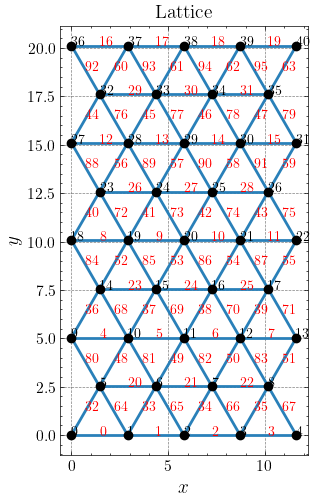

In [6]:
n1 = 4
n2 = 8

spacing = LTNI_all_x_pos[3, 0] - LTNI_all_x_pos[4, 0] # needs to be manually determined bc of inconsistent indexing in experimental data
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(n1=n1, n2=n2)

# connectivity = triangular_lattice_connectivity(n1=n1, n2=n2)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,
    young=jnp.ones(n_bonds),
    area=jnp.ones(n_bonds)*(4*0.125**2),
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
plot_lattice(lattice, annotate=True, figsize=(5, 5))

In [7]:
horizontal_bonds_indices = jnp.arange(0, len(horiz_bonds_even)+len(horiz_bonds_odd))
right_leaning_indices = jnp.arange(horizontal_bonds_indices[-1]+1, horizontal_bonds_indices[-1]+1 + len(right_lean_even) + len(right_lean_odd))
left_leaning_indices = jnp.arange(right_leaning_indices[-1]+1, right_leaning_indices[-1]+1 + len(left_lean_even) + len(left_lean_odd))


def HTNI_all_young(t):
    young = jnp.ones(n_bonds)*HTNI_young_fit_fine(T(t))
    return young

def HTNI_all_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)*(HTNI_stretch(T(t))-1)*0.8
    return thermal_strain

def LTNI_all_young(t):
    young = jnp.ones(n_bonds)*LTNI_young_fit_fine(T(t))
    return young

def LTNI_all_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)*(LTNI_stretch(T(t))-1)*0.7
    return thermal_strain

def HTNI_teeth_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[horizontal_bonds_indices].set(LTNI_young_fit_fine(T(t)))
    young = young.at[jnp.concatenate([right_leaning_indices, left_leaning_indices])].set(HTNI_young_fit_fine(T(t)))

    return young

def HTNI_teeth_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[horizontal_bonds_indices].set((LTNI_stretch(T(t))-1)*0.7)
    thermal_strain = thermal_strain.at[jnp.concatenate([right_leaning_indices, left_leaning_indices])].set((HTNI_stretch(T(t))-1)*0.8)

    return thermal_strain

def LTNI_teeth_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[horizontal_bonds_indices].set(HTNI_young_fit_fine(T(t)))
    young = young.at[jnp.concatenate([right_leaning_indices, left_leaning_indices])].set(LTNI_young_fit_fine(T(t)))

    return young

def LTNI_teeth_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[horizontal_bonds_indices].set((HTNI_stretch(T(t))-1)*0.8)
    thermal_strain = thermal_strain.at[jnp.concatenate([right_leaning_indices, left_leaning_indices])].set((LTNI_stretch(T(t))-1)*0.7)

    return thermal_strain

def HTNI_pacman_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[jnp.concatenate([horizontal_bonds_indices, right_leaning_indices])].set(HTNI_young_fit_fine(T(t)))
    young = young.at[left_leaning_indices].set(LTNI_young_fit_fine(T(t)))

    return young

def HTNI_pacman_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[jnp.concatenate([horizontal_bonds_indices, right_leaning_indices])].set((HTNI_stretch(T(t))-1)*0.8)
    thermal_strain = thermal_strain.at[left_leaning_indices].set((LTNI_stretch(T(t))-1)*0.7)

    return thermal_strain

def LTNI_pacman_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[jnp.concatenate([horizontal_bonds_indices, right_leaning_indices])].set(LTNI_young_fit_fine(T(t)))
    young = young.at[left_leaning_indices].set(HTNI_young_fit_fine(T(t)))

    return young

def LTNI_pacman_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[jnp.concatenate([horizontal_bonds_indices, right_leaning_indices])].set((LTNI_stretch(T(t))-1)*0.7)
    thermal_strain = thermal_strain.at[left_leaning_indices].set((HTNI_stretch(T(t))-1)*0.8)

    return thermal_strain


def strut_properties(lattice_name: str):
    if lattice_name == 'HTNI_all':
        youngs_modulus_fn = HTNI_all_young
        thermal_strain_fn = HTNI_all_thermalstrain
    elif lattice_name == 'LTNI_all':
        youngs_modulus_fn = LTNI_all_young
        thermal_strain_fn = LTNI_all_thermalstrain
    elif lattice_name == 'HTNI_teeth':
        youngs_modulus_fn = HTNI_teeth_young
        thermal_strain_fn = HTNI_teeth_thermalstrain
    elif lattice_name == 'LTNI_teeth':
        youngs_modulus_fn = LTNI_teeth_young
        thermal_strain_fn = LTNI_teeth_thermalstrain
    elif lattice_name == 'HTNI_pacman':
        youngs_modulus_fn = HTNI_pacman_young
        thermal_strain_fn = HTNI_pacman_thermalstrain
    elif lattice_name == 'LTNI_pacman':
        youngs_modulus_fn = LTNI_pacman_young
        thermal_strain_fn = LTNI_pacman_thermalstrain

    return youngs_modulus_fn, thermal_strain_fn


In [19]:
# Choose lattice topology:
# 'HTNI_all', 'LTNI_all', 'HTNI_teeth', 'LTNI_teeth', 'HTNI_pacman', 'LTNI_pacman'
youngs_modulus_fn, thermal_strain_fn = strut_properties('LTNI_pacman')

# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])
timepoints = jnp.linspace(0, ts[-1], 500)
temp_evolution = T(timepoints) # used for plotting

def control_params_fn(t, control_params: ControlParams):
    return control_params._replace(
        young = youngs_modulus_fn(t),
        thermal_strain = thermal_strain_fn(t)
    )


solve_dynamics, _ = setup_dynamic_solver(
    lattice=lattice,
    control_params_fn=control_params_fn,
    constrained_point_DOF_pairs=jnp.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [
                                          2, 1], [3, 0], [3, 1], [4, 0], [4, 1]]),
    rigid_bodies_points=[jnp.arange(lattice.n_points-n1-1, lattice.n_points)],  # Last row is a rigid body
)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)

strain_fn = build_strain_fn(lattice.connectivity)


(<Figure size 500x500 with 2 Axes>,
 <Axes: title={'center': 'Final state'}, xlabel='$x$', ylabel='$y$'>)

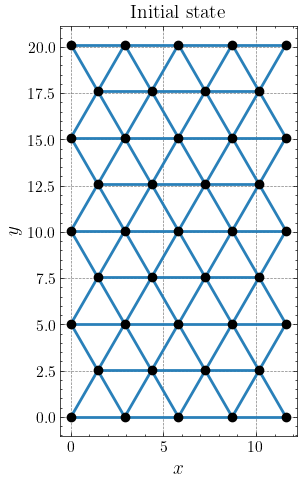

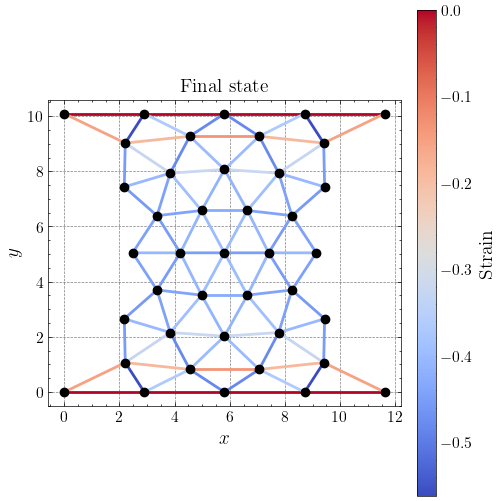

In [9]:
plot_lattice(lattice, lattice.solution[0, 0], title='Initial state', figsize=(3, 6))
plot_lattice(lattice, lattice.solution[-1, 0], title='Final state', figsize=(5, 5),
             bond_values=strain_fn(lattice.control_params.reference_points, lattice.solution[-1, 0]),
             label='Strain')


### HTNI Numerical and Experimental comparison

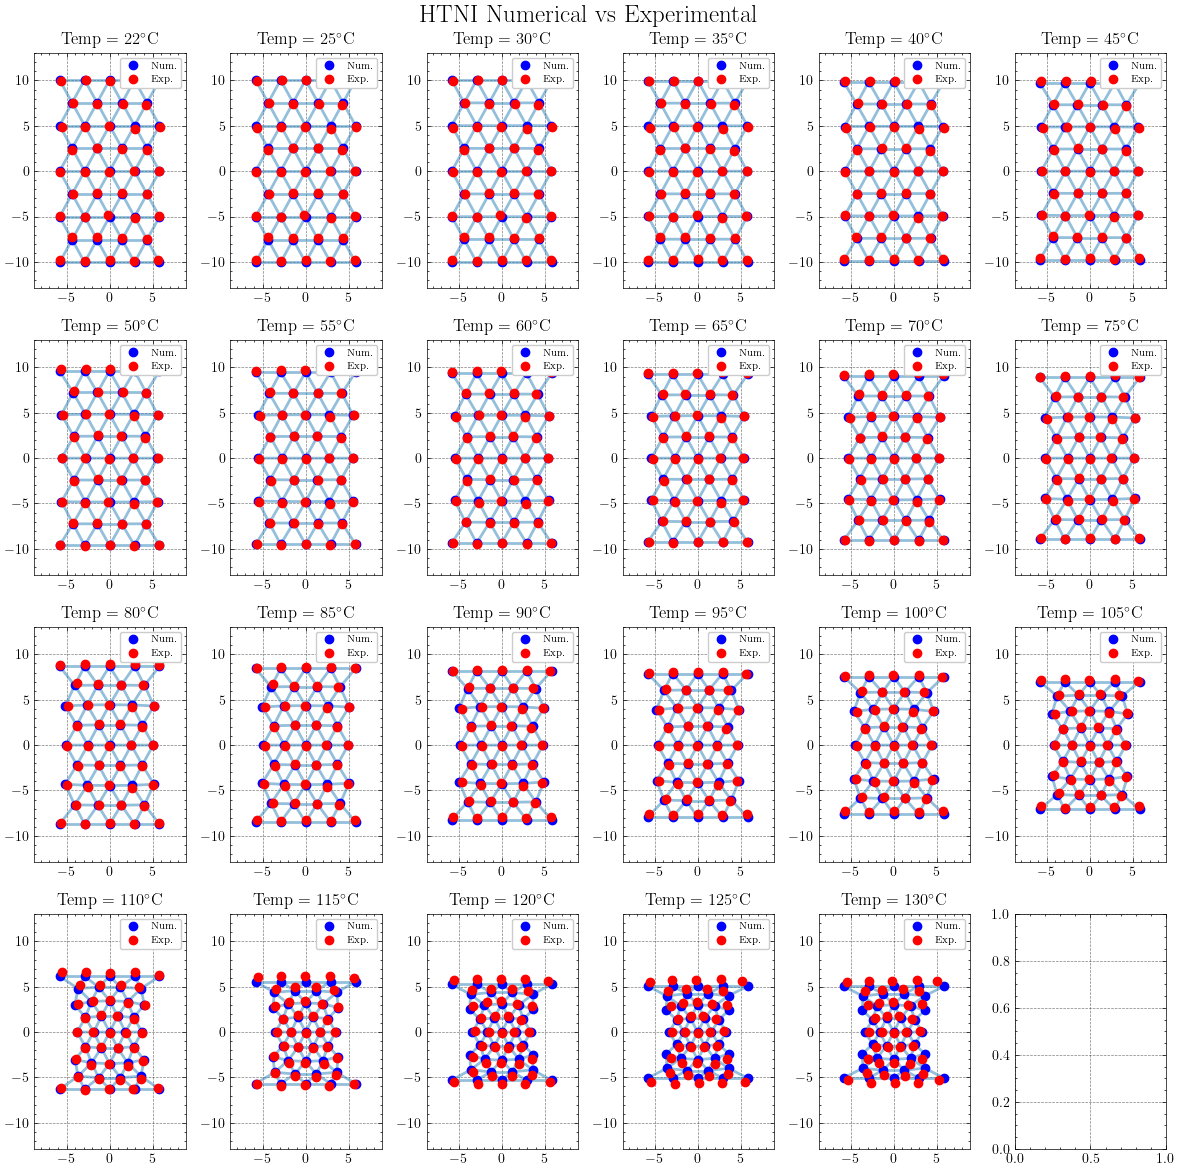

In [10]:
fig, ax = plt.subplots(4, 6, figsize = [12, 12])

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            if origin_at_central_node:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
            else:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

            for pair in lattice.connectivity:
                ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

            ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
            ax[i, j].plot(HTNI_all_x_pos[:, exp_idx_i], HTNI_all_y_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_ylim([min(HTNI_all_y_pos[:, 0]) - 3, max(HTNI_all_y_pos[:, 0]) + 3])
            ax[i, j].set_xlim([min(HTNI_all_x_pos[:, 0]) - 3, max(HTNI_all_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

plt.suptitle('HTNI Numerical vs Experimental', fontsize=18)
plt.tight_layout()

### LTNI Numerical and Experimental Comparison

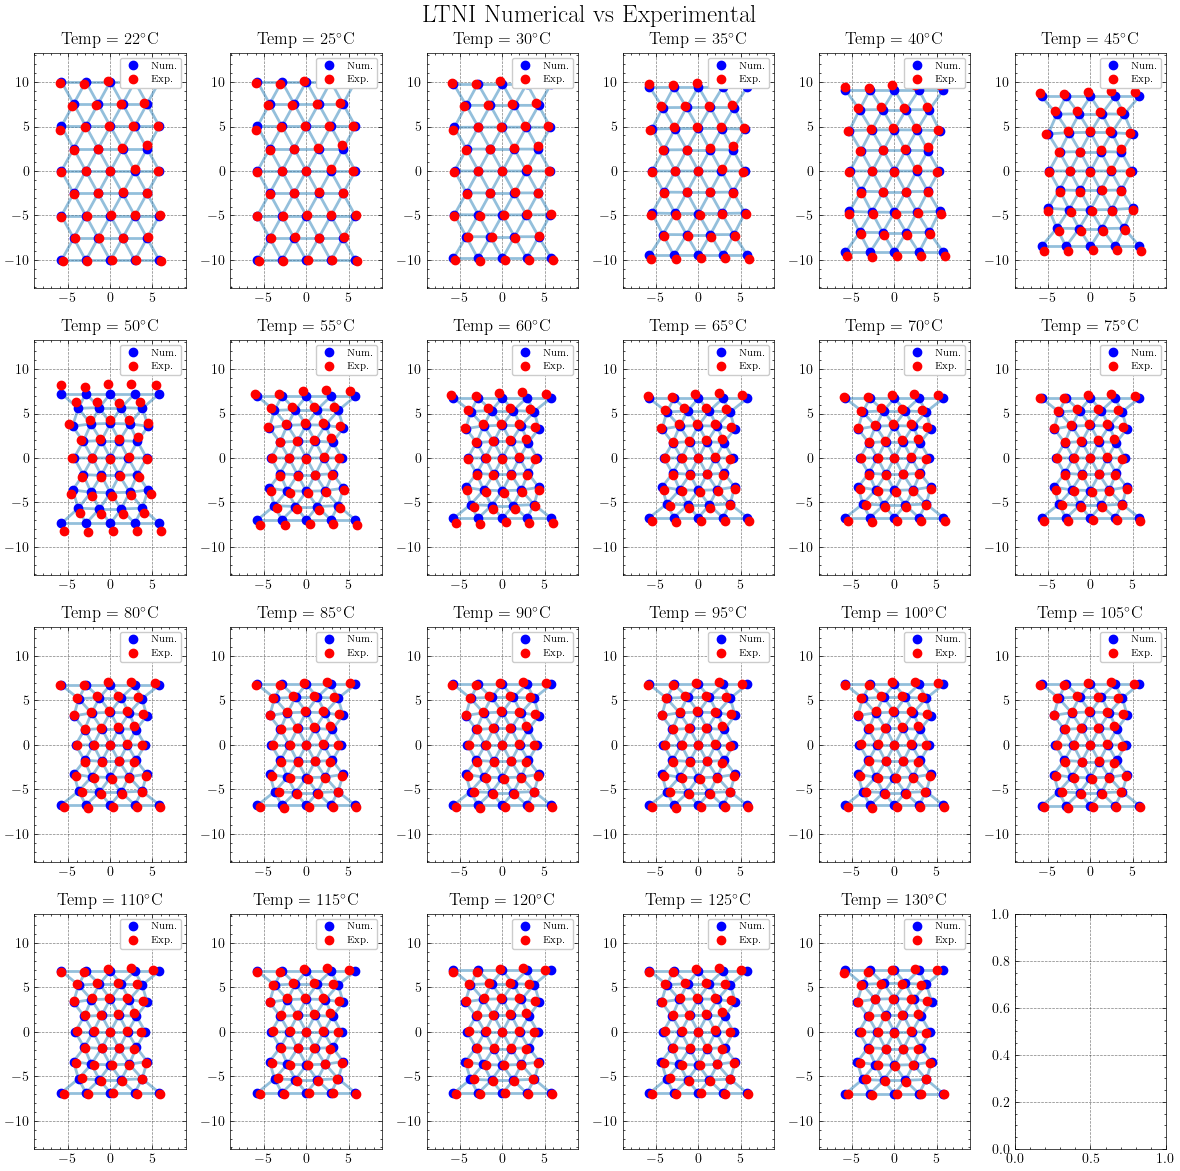

In [12]:
fig, ax = plt.subplots(4, 6, figsize = [12, 12])

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            if origin_at_central_node:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
            else:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

            for pair in lattice.connectivity:
                ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

            ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
            ax[i, j].plot(LTNI_all_x_pos[:, exp_idx_i], LTNI_all_y_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_ylim([min(LTNI_all_y_pos[:, 0]) - 3, max(LTNI_all_y_pos[:, 0]) + 3])
            ax[i, j].set_xlim([min(LTNI_all_x_pos[:, 0]) - 3, max(LTNI_all_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

plt.suptitle('LTNI Numerical vs Experimental', fontsize=18)
plt.tight_layout()

### HTNI teeth Numerical and Experimental Comparison

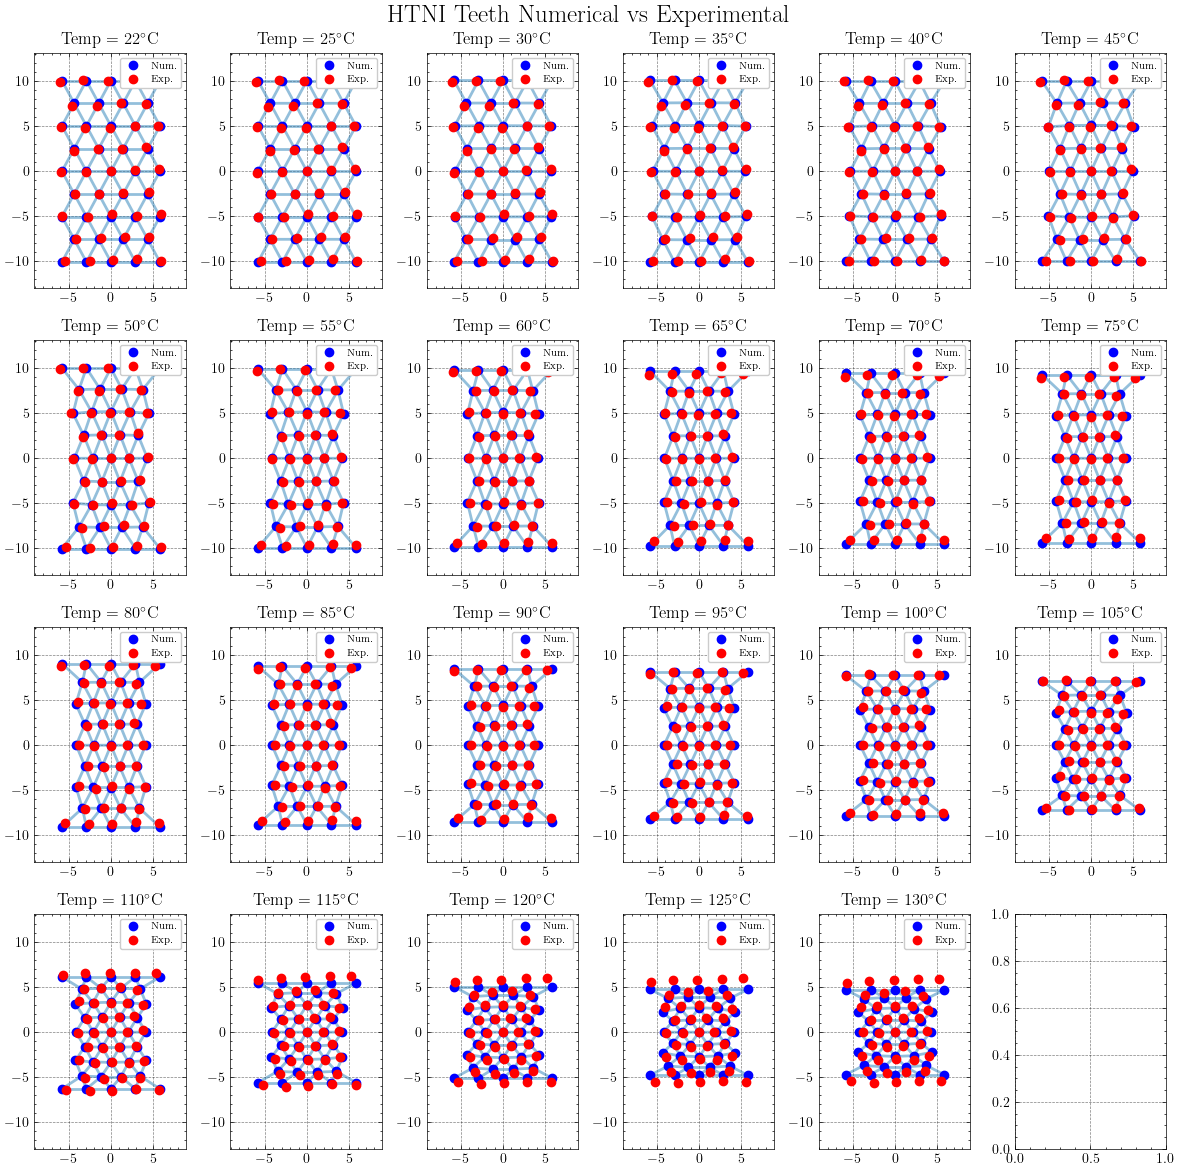

In [14]:
fig, ax = plt.subplots(4, 6, figsize = [12, 12])

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            if origin_at_central_node:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
            else:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

            for pair in lattice.connectivity:
                ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

            ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
            ax[i, j].plot(HTNI_teeth_x_pos[:, exp_idx_i], HTNI_teeth_y_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_ylim([min(HTNI_teeth_y_pos[:, 0]) - 3, max(HTNI_teeth_y_pos[:, 0]) + 3])
            ax[i, j].set_xlim([min(HTNI_teeth_x_pos[:, 0]) - 3, max(HTNI_teeth_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

plt.suptitle('HTNI Teeth Numerical vs Experimental', fontsize=18)
plt.tight_layout()

### LTNI teeth Numerical and Experimental Comparison

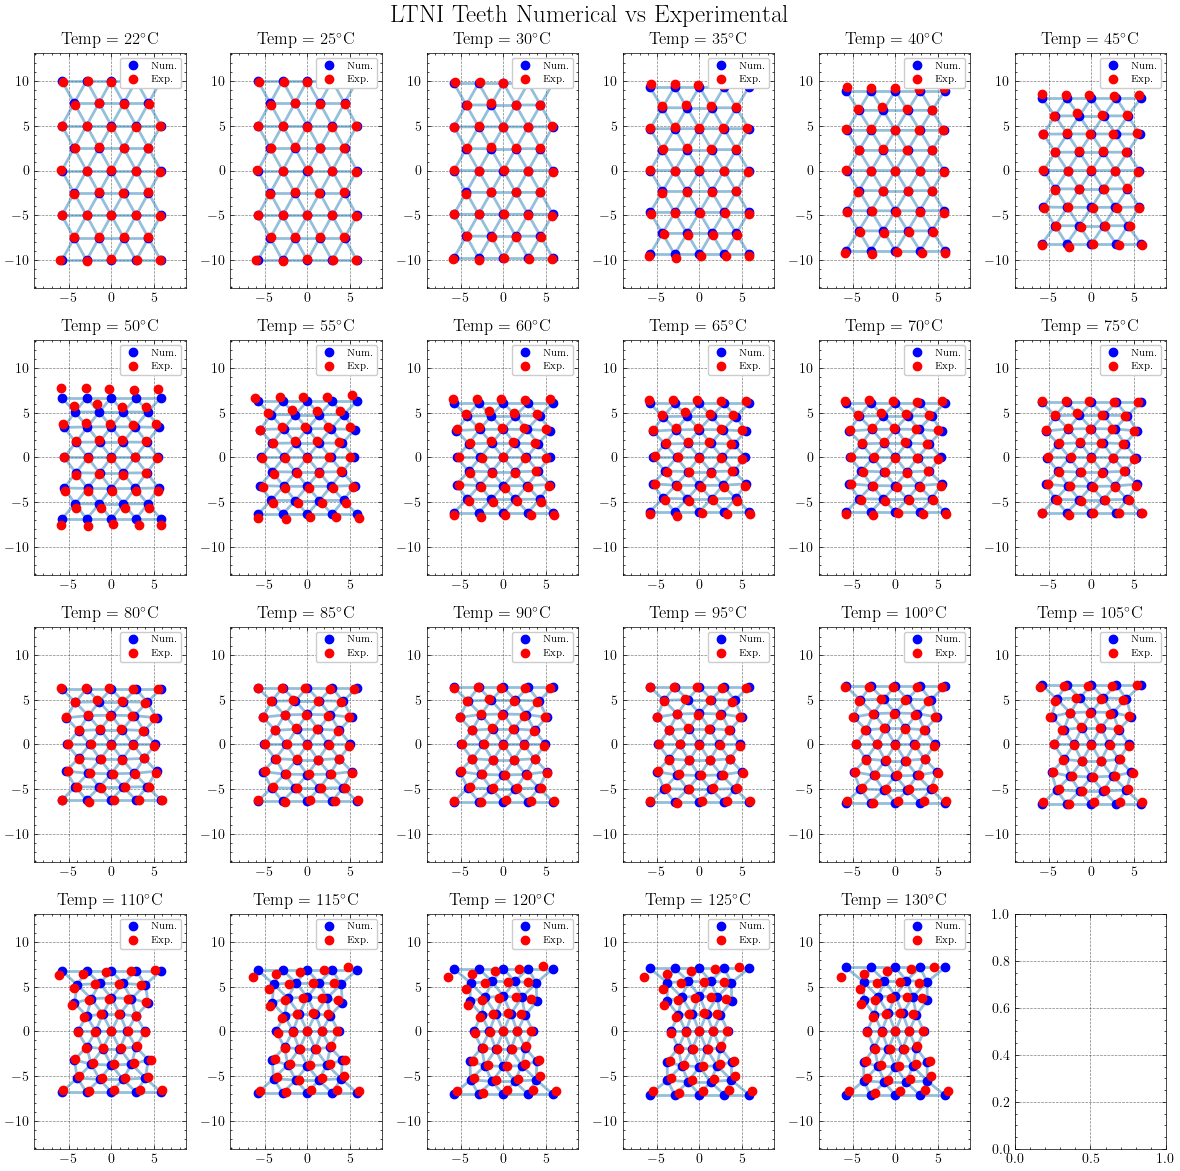

In [16]:
fig, ax = plt.subplots(4, 6, figsize = [12, 12])

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            if origin_at_central_node:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
            else:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

            for pair in lattice.connectivity:
                ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

            ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
            ax[i, j].plot(LTNI_teeth_x_pos[:, exp_idx_i], LTNI_teeth_y_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_ylim([min(LTNI_teeth_y_pos[:, 0]) - 3, max(LTNI_teeth_y_pos[:, 0]) + 3])
            ax[i, j].set_xlim([min(LTNI_teeth_x_pos[:, 0]) - 3, max(LTNI_teeth_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

plt.suptitle('LTNI Teeth Numerical vs Experimental', fontsize=18)
plt.tight_layout()

### HTNI pacman Numerical and Experimental Comparison

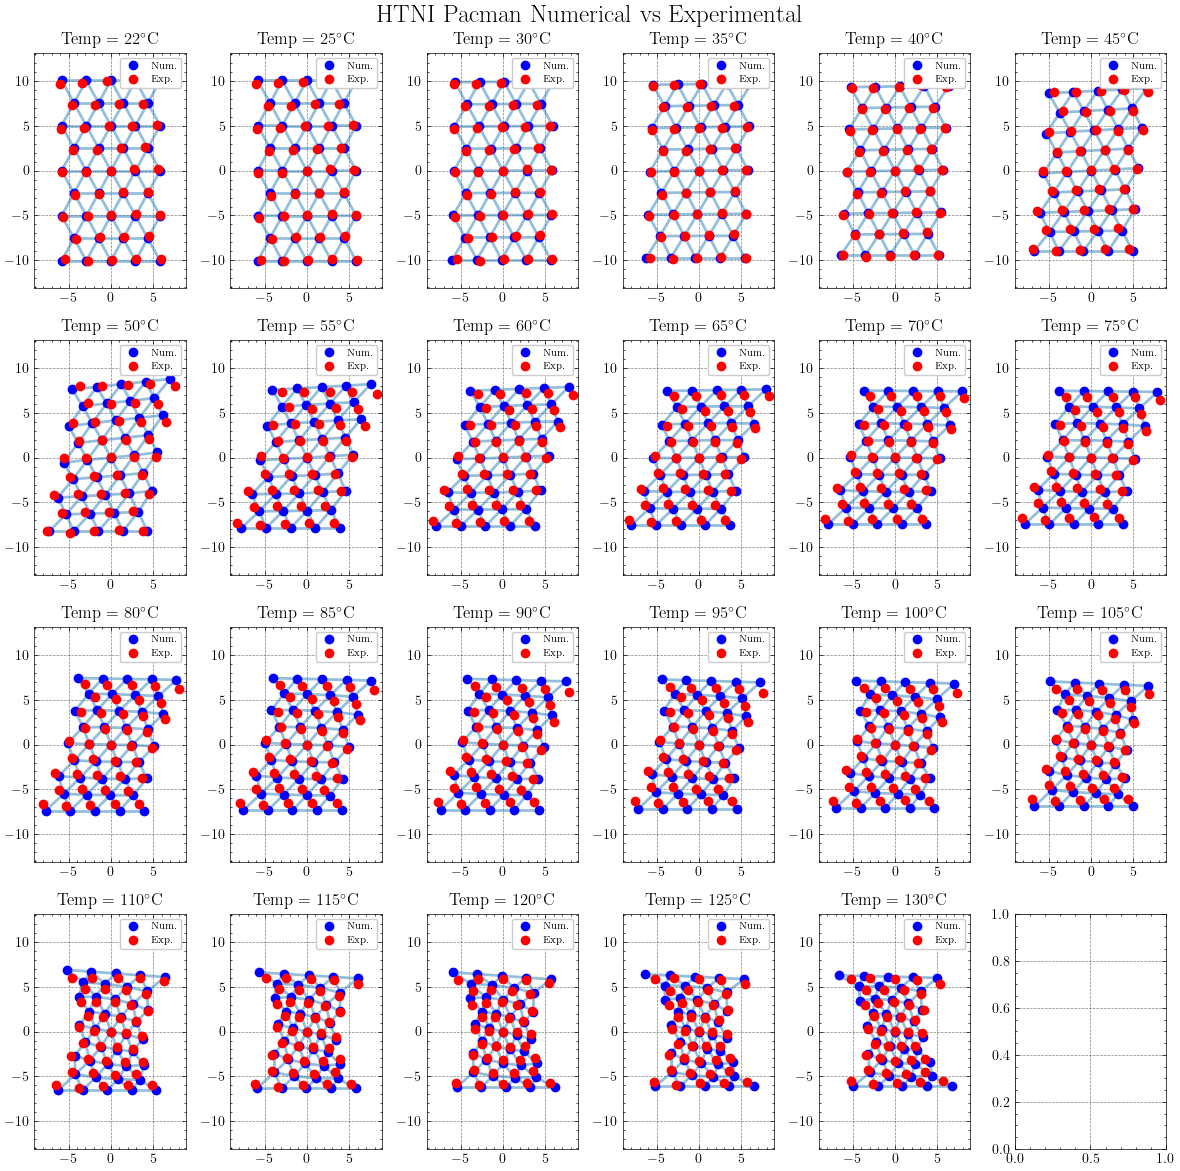

In [18]:
fig, ax = plt.subplots(4, 6, figsize = [12, 12])

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            if origin_at_central_node:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
            else:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

            for pair in lattice.connectivity:
                ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

            ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')

            ax[i, j].plot(HTNI_pacman_x_pos[:, exp_idx_i], HTNI_pacman_y_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_ylim([min(HTNI_pacman_y_pos[:, 0]) - 3, max(HTNI_pacman_y_pos[:, 0]) + 3])
            ax[i, j].set_xlim([min(HTNI_pacman_x_pos[:, 0]) - 3, max(HTNI_pacman_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

plt.suptitle('HTNI Pacman Numerical vs Experimental', fontsize=18)
plt.tight_layout()

### LTNI pacman Numerical and Experimental Comparison

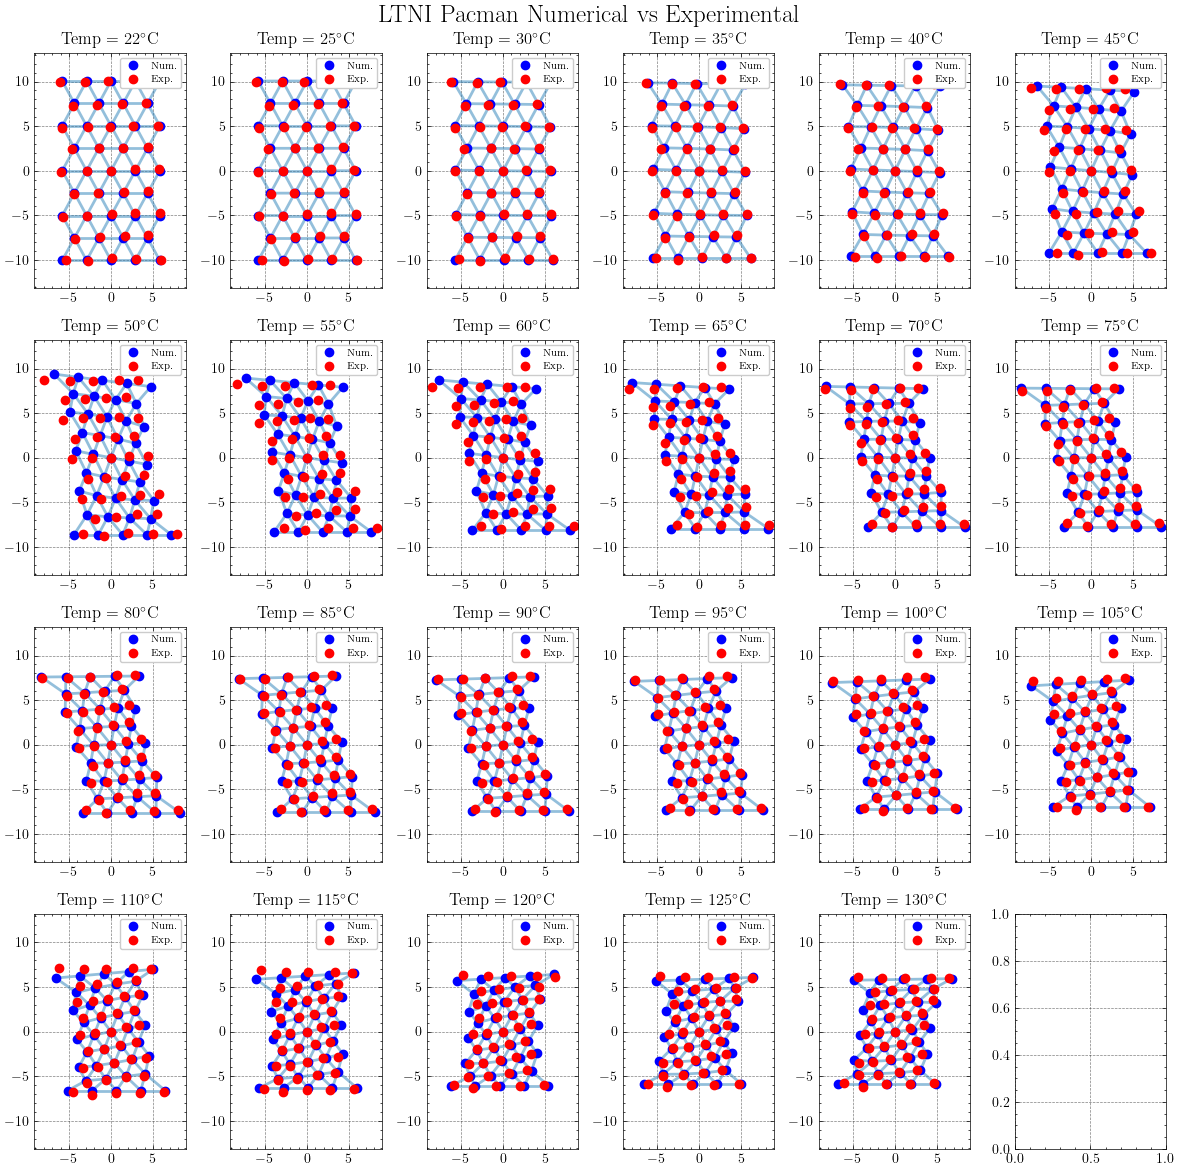

In [20]:
fig, ax = plt.subplots(4, 6, figsize = [12, 12])
counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            if origin_at_central_node:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
            else:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

            for pair in lattice.connectivity:
                ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

            ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
            ax[i, j].plot(LTNI_pacman_x_pos[:, exp_idx_i], LTNI_pacman_y_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_ylim([min(LTNI_pacman_y_pos[:, 0]) - 3, max(LTNI_pacman_y_pos[:, 0]) + 3])
            ax[i, j].set_xlim([min(LTNI_pacman_x_pos[:, 0]) - 3, max(LTNI_pacman_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

plt.suptitle('LTNI Pacman Numerical vs Experimental', fontsize=18)
plt.tight_layout()